In this notebook, we go through methods denoising/detoning matrix, especially covariance and correlation matrix. The detail of implementations will be found at finance_ml/denoising.py.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Marcenko-Pastur Theorem

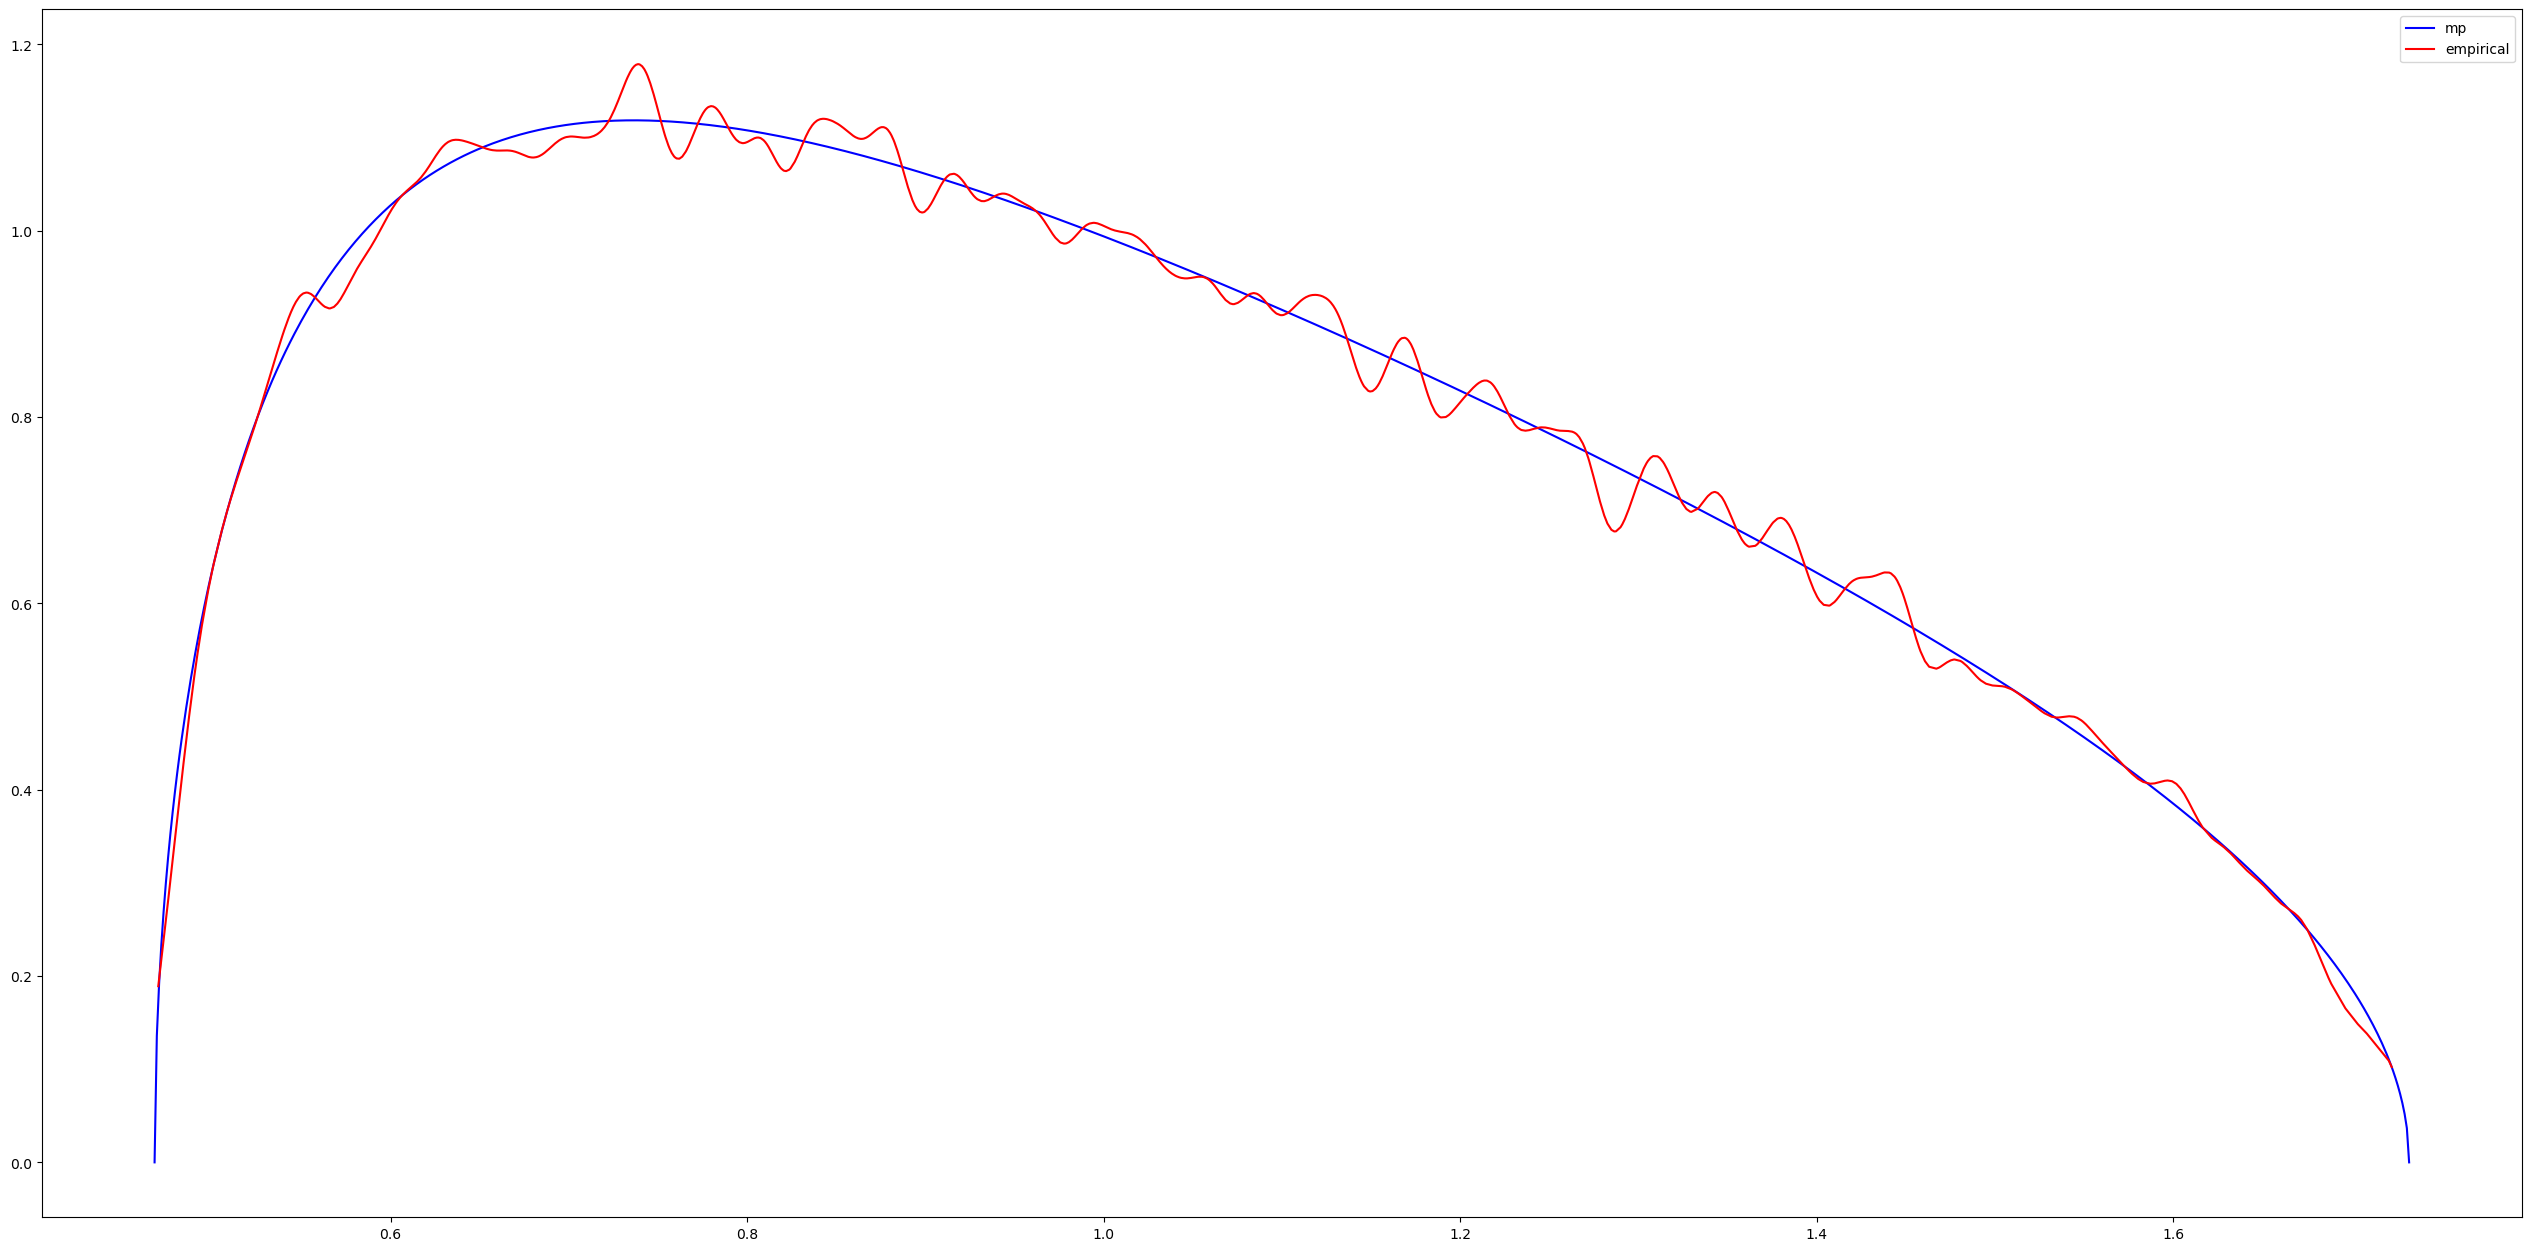

In [3]:
from finance_ml.denoising import getPCA, mp_pdf, fitKDE

T = 10000
N = 1000
x = np.random.normal(size=(T, N))
e_val0, e_vec0 = getPCA(np.corrcoef(x, rowvar=0))
pdf0 = mp_pdf(1., q=x.shape[0]/float(x.shape[1]), pts=1000)
pdf1 = fitKDE(np.diag(e_val0), bwidth=0.01)
plt.plot(pdf0, color='b', label='mp');
plt.plot(pdf1, color='r', label='empirical');
plt.legend();

The blue line is theoretical aymptotic distribution of eigenvalues of $C=T^{-1} X^t X$ where N >> 1, T >> 1, T/N >> 1, and X is matrix of i.i.d random column vector with shape=(T, N). (Marcenko-Pastur Theorem). The red line is an empirical distirbution generated from normal distribution of N=1e3, T=1e4. You see how closely the theorem describe the eigen value distribution.

# Random Matrix with Signal

We consider the case where both signal and noise co-exists with the folloing experiments.
As a noise, we generate covariace generated from (n_cols * q samples, n_cols) shape gaussian distributed vectors. As a signal covariance generated from n_facts dimention independent vectors, i.e., n_facts rank matrix contaminated with noise. Theoretically speaking, you will see n_facts significant eigen values out of n_cols eigen values.

n_facts=100, var=0.6764666033951251


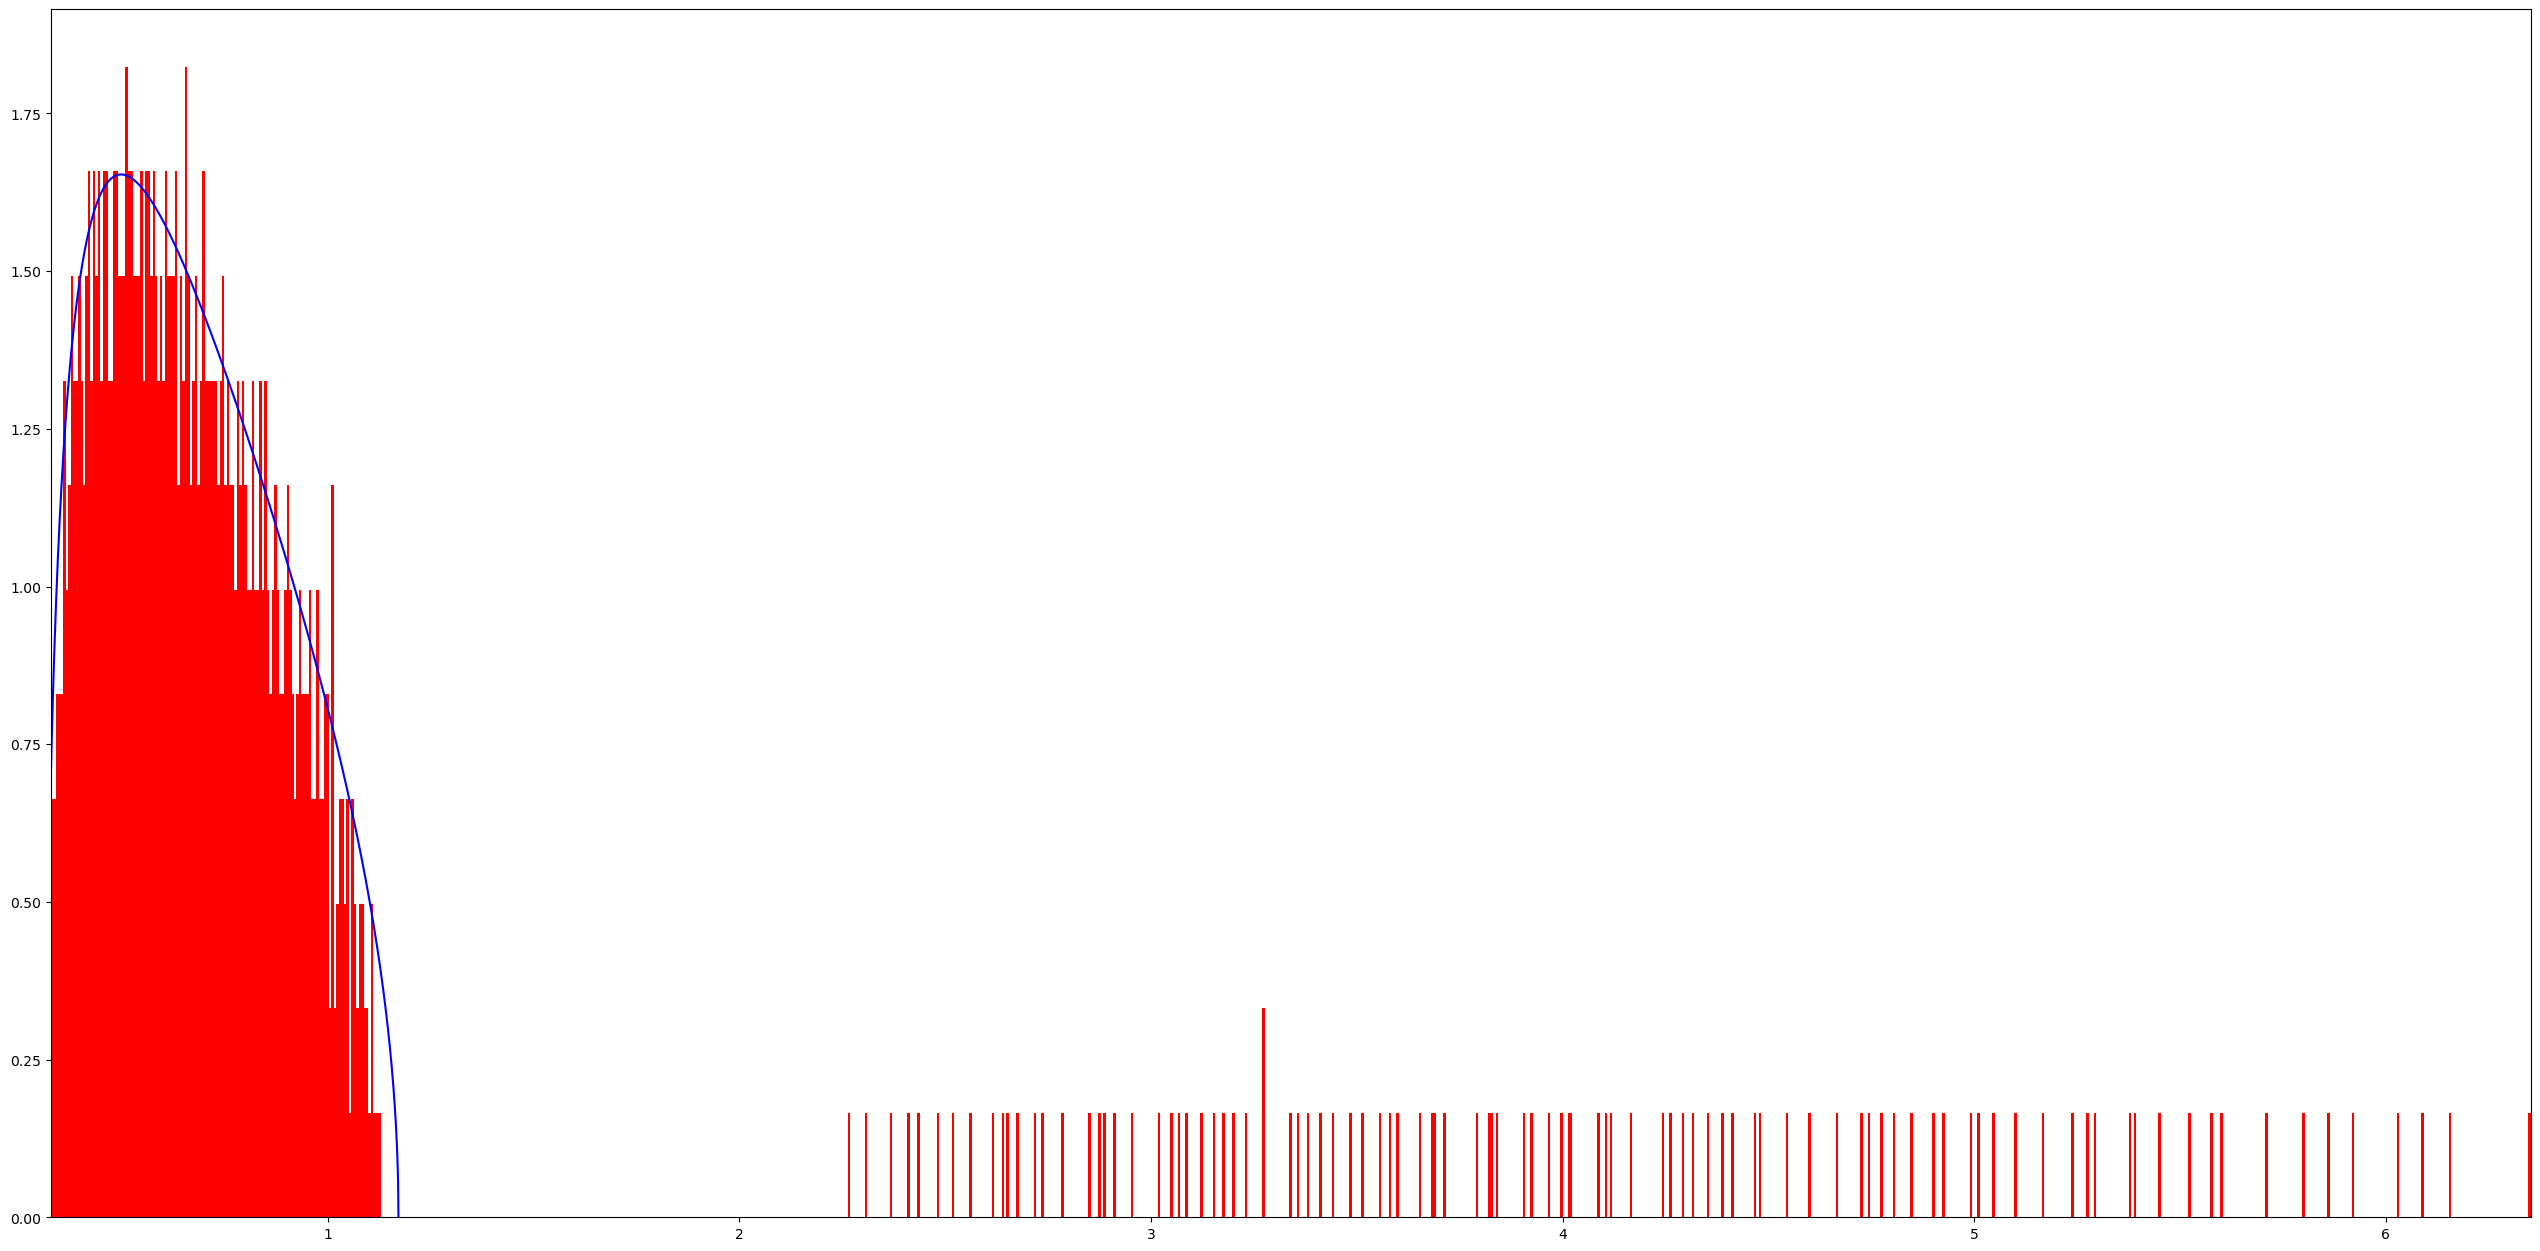

In [5]:
from finance_ml.experiments import get_random_cov
from finance_ml.denoising import getPCA, mp_pdf, fitKDE, cov2corr, find_max_eigen_val

alpha = 0.995
n_cols = 1000
n_facts = 100
q = 10 # T/N

noise_cov = np.cov(np.random.normal(size=(n_cols * q, n_cols)), rowvar=0)
cov = alpha * noise_cov + (1 - alpha) * get_random_cov(n_cols, n_facts)
corr0 = cov2corr(cov)
e_val0, e_vec0 = getPCA(corr0)
e_max0, var0 = find_max_eigen_val(np.diag(e_val0), q, bwidth=0.01)
n_facts0 = e_val0.shape[0] - np.diag(e_val0)[::-1].searchsorted(e_max0)
print(f"n_facts={n_facts0}, var={var0}")
pdf0 = mp_pdf(var0, q=x.shape[0]/float(x.shape[1]), pts=1000)
pdf0.plot(color='b');
samples = np.diag(e_val0)
bins = np.linspace(samples.min(), samples.max(), 1000)
plt.hist(samples, color='r', density=True, bins=bins);
plt.xlim(samples.min(), samples.max());

`find_max_eigen_val` returns variance and $\lambda_{+}$ of Marcenko-Pastur Theorem fitted on data. $\lambda_{+}$ found through `find_max_eigen_val` is the 100th biggest eigen value, which seems to match up with the theory. The blue line is the fitted distribution of Marcenko-Pastur Theorem distribution.

# Denoising

From the previous result, we can conduct denoising correlation based on eigen values and vectors, `denoise_corr`. The simplest one is averaging noise components, `shrinkage=False`. The other method is adding non-diagonal part of noise components with only `alpha` ratio, `shrinkage=True`.

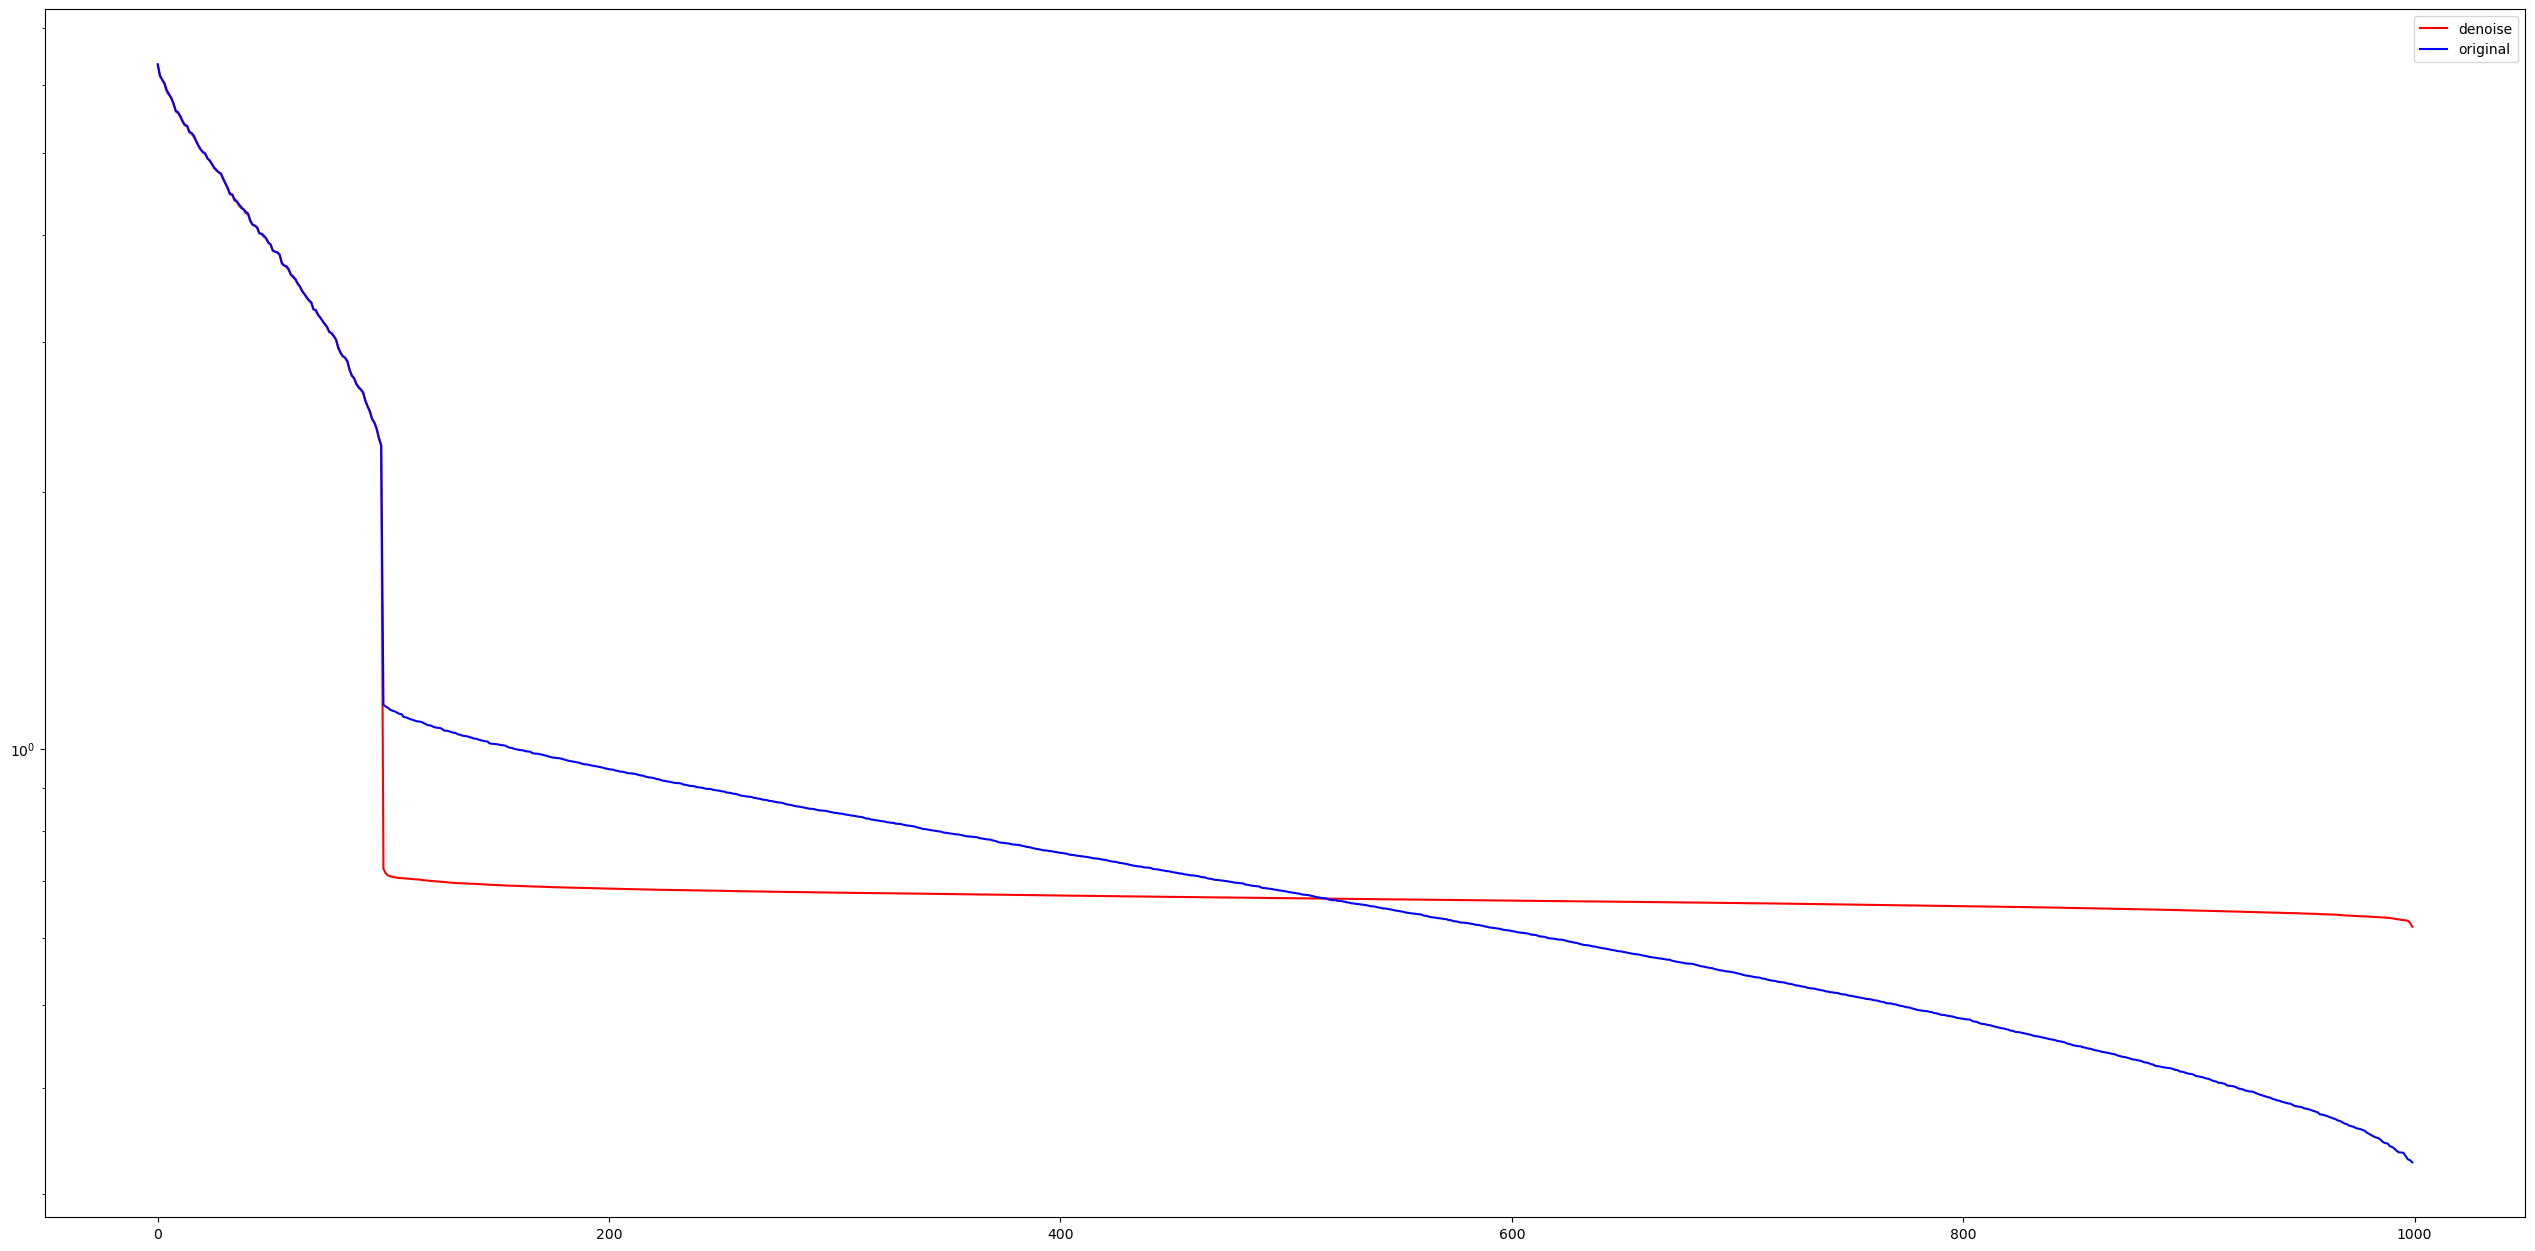

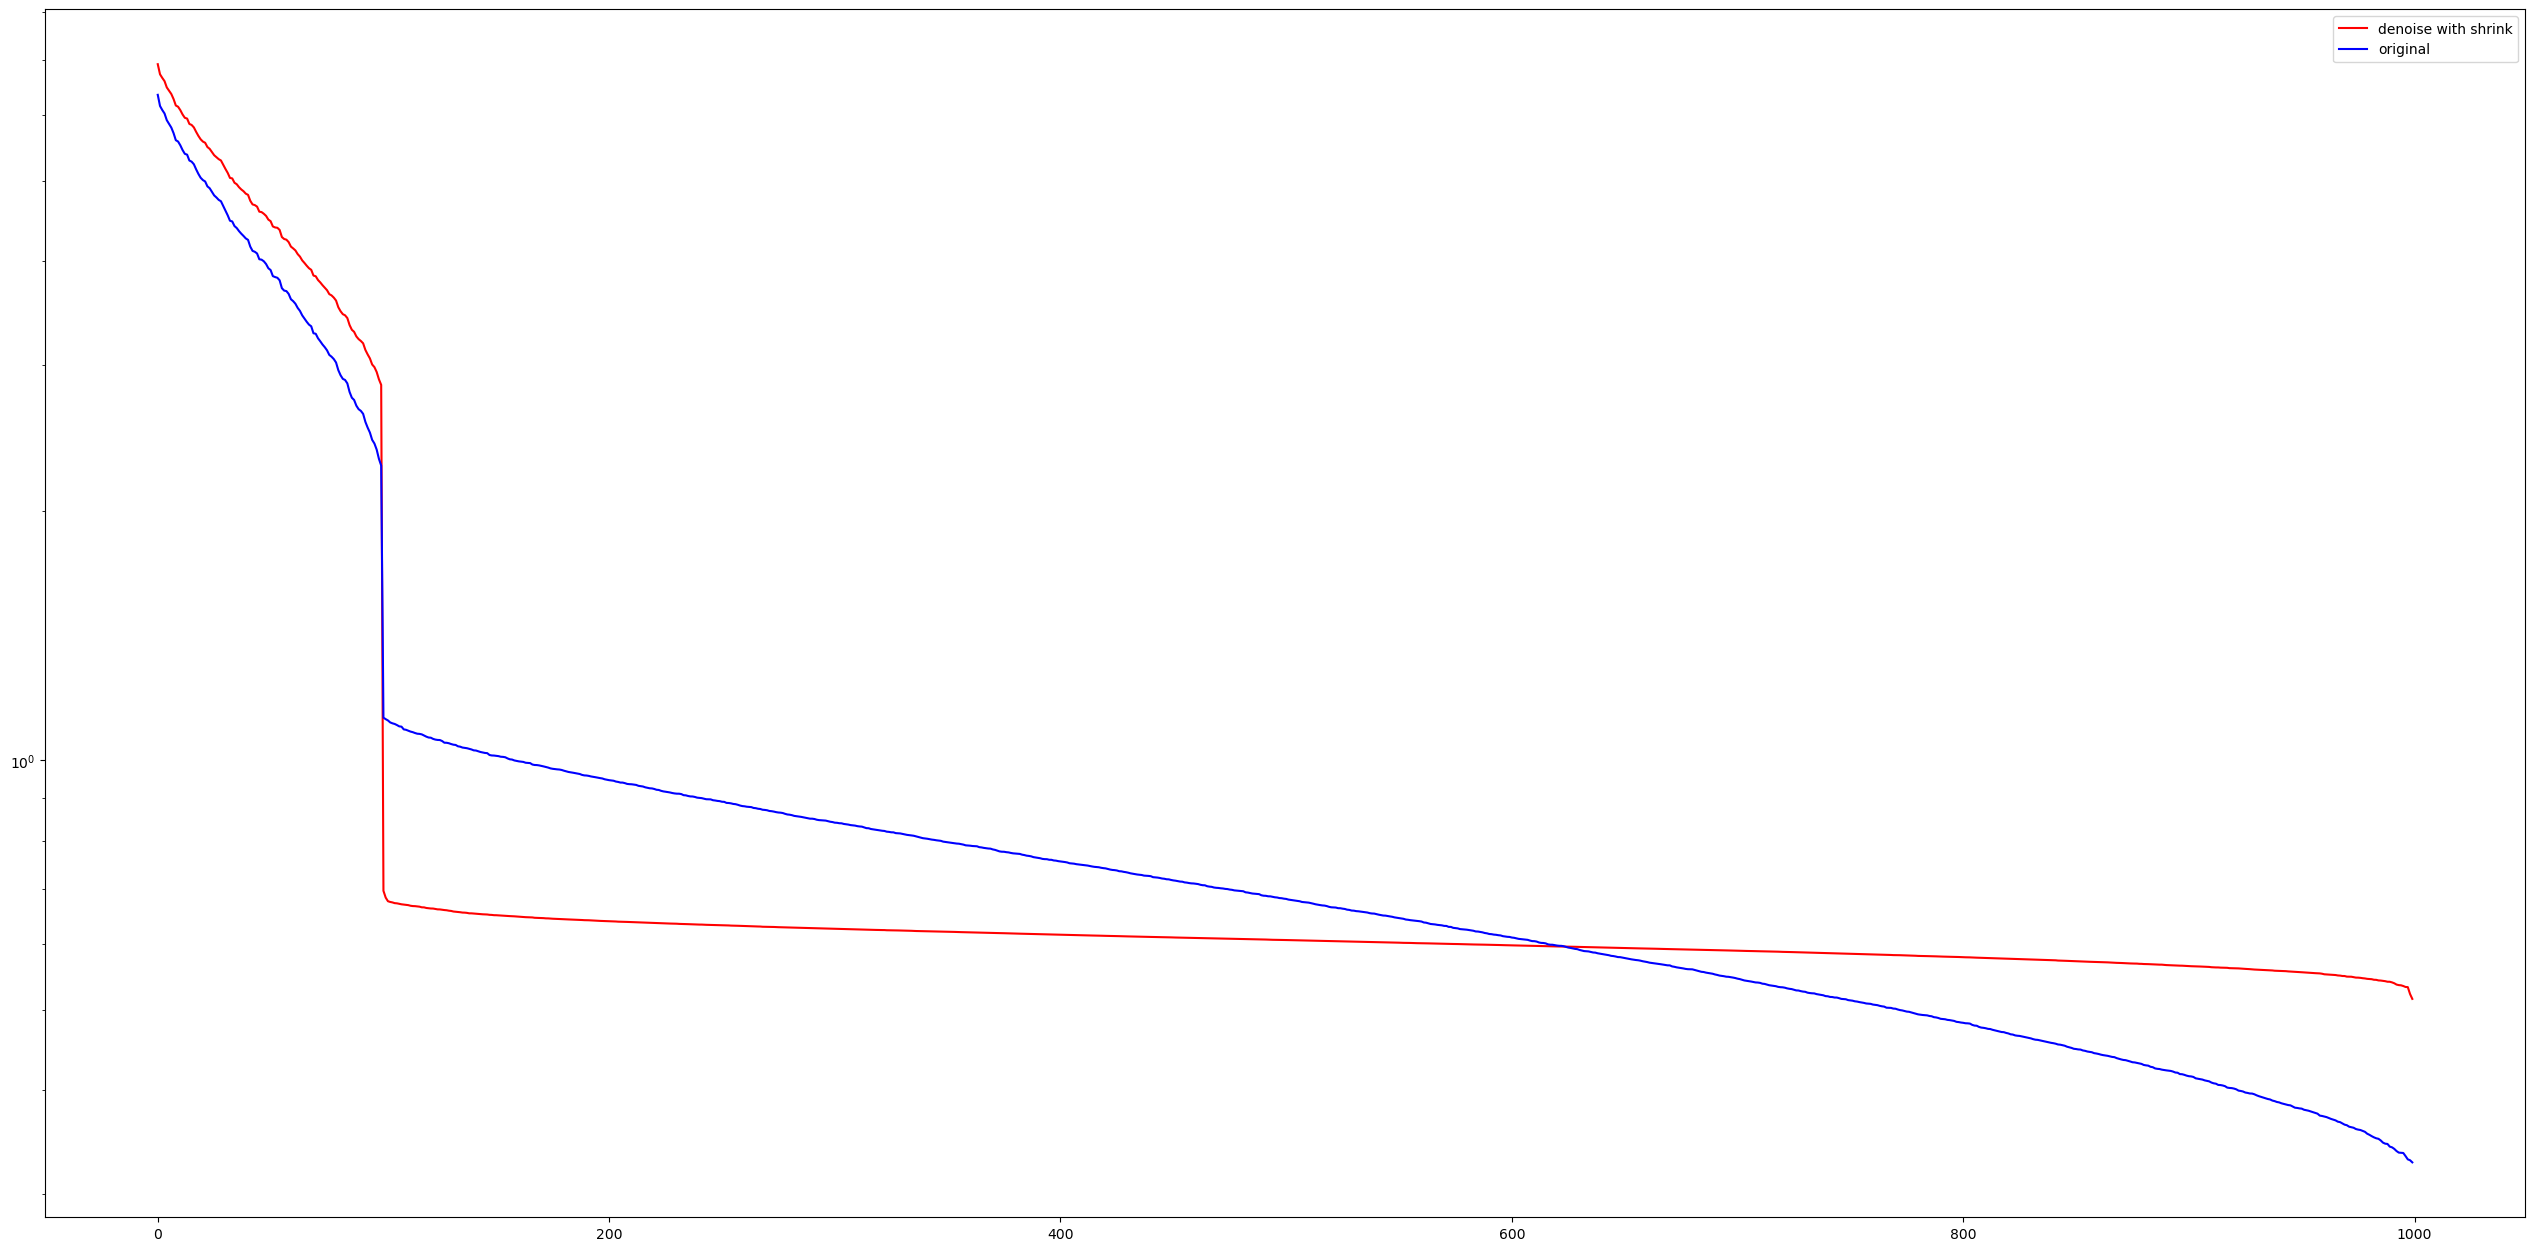

In [6]:
from finance_ml.denoising import denoise_corr

plt.figure()
corr1 = denoise_corr(e_val0, e_vec0, n_facts0, shrinkage=False)
e_val1, e_vec1 = getPCA(corr1)
plt.plot(np.diag(e_val1), color='r', label='denoise');
plt.plot(np.diag(e_val0), color='b', label='original');
plt.yscale('log');
plt.legend();

plt.figure()
corr1 = denoise_corr(e_val0, e_vec0, n_facts0, shrinkage=True, alpha=0.05)
e_val1, e_vec1 = getPCA(corr1)
plt.plot(np.diag(e_val1), color='r', label='denoise with shrink');
plt.plot(np.diag(e_val0), color='b', label='original');
plt.yscale('log');
plt.legend();

# Detoning

In financial market, the first eigen vector of correlation matrix is market component. In the clustering, it is useful to remove strong market component. After removing, you can focus on comparatively weak component to conduct clustering.

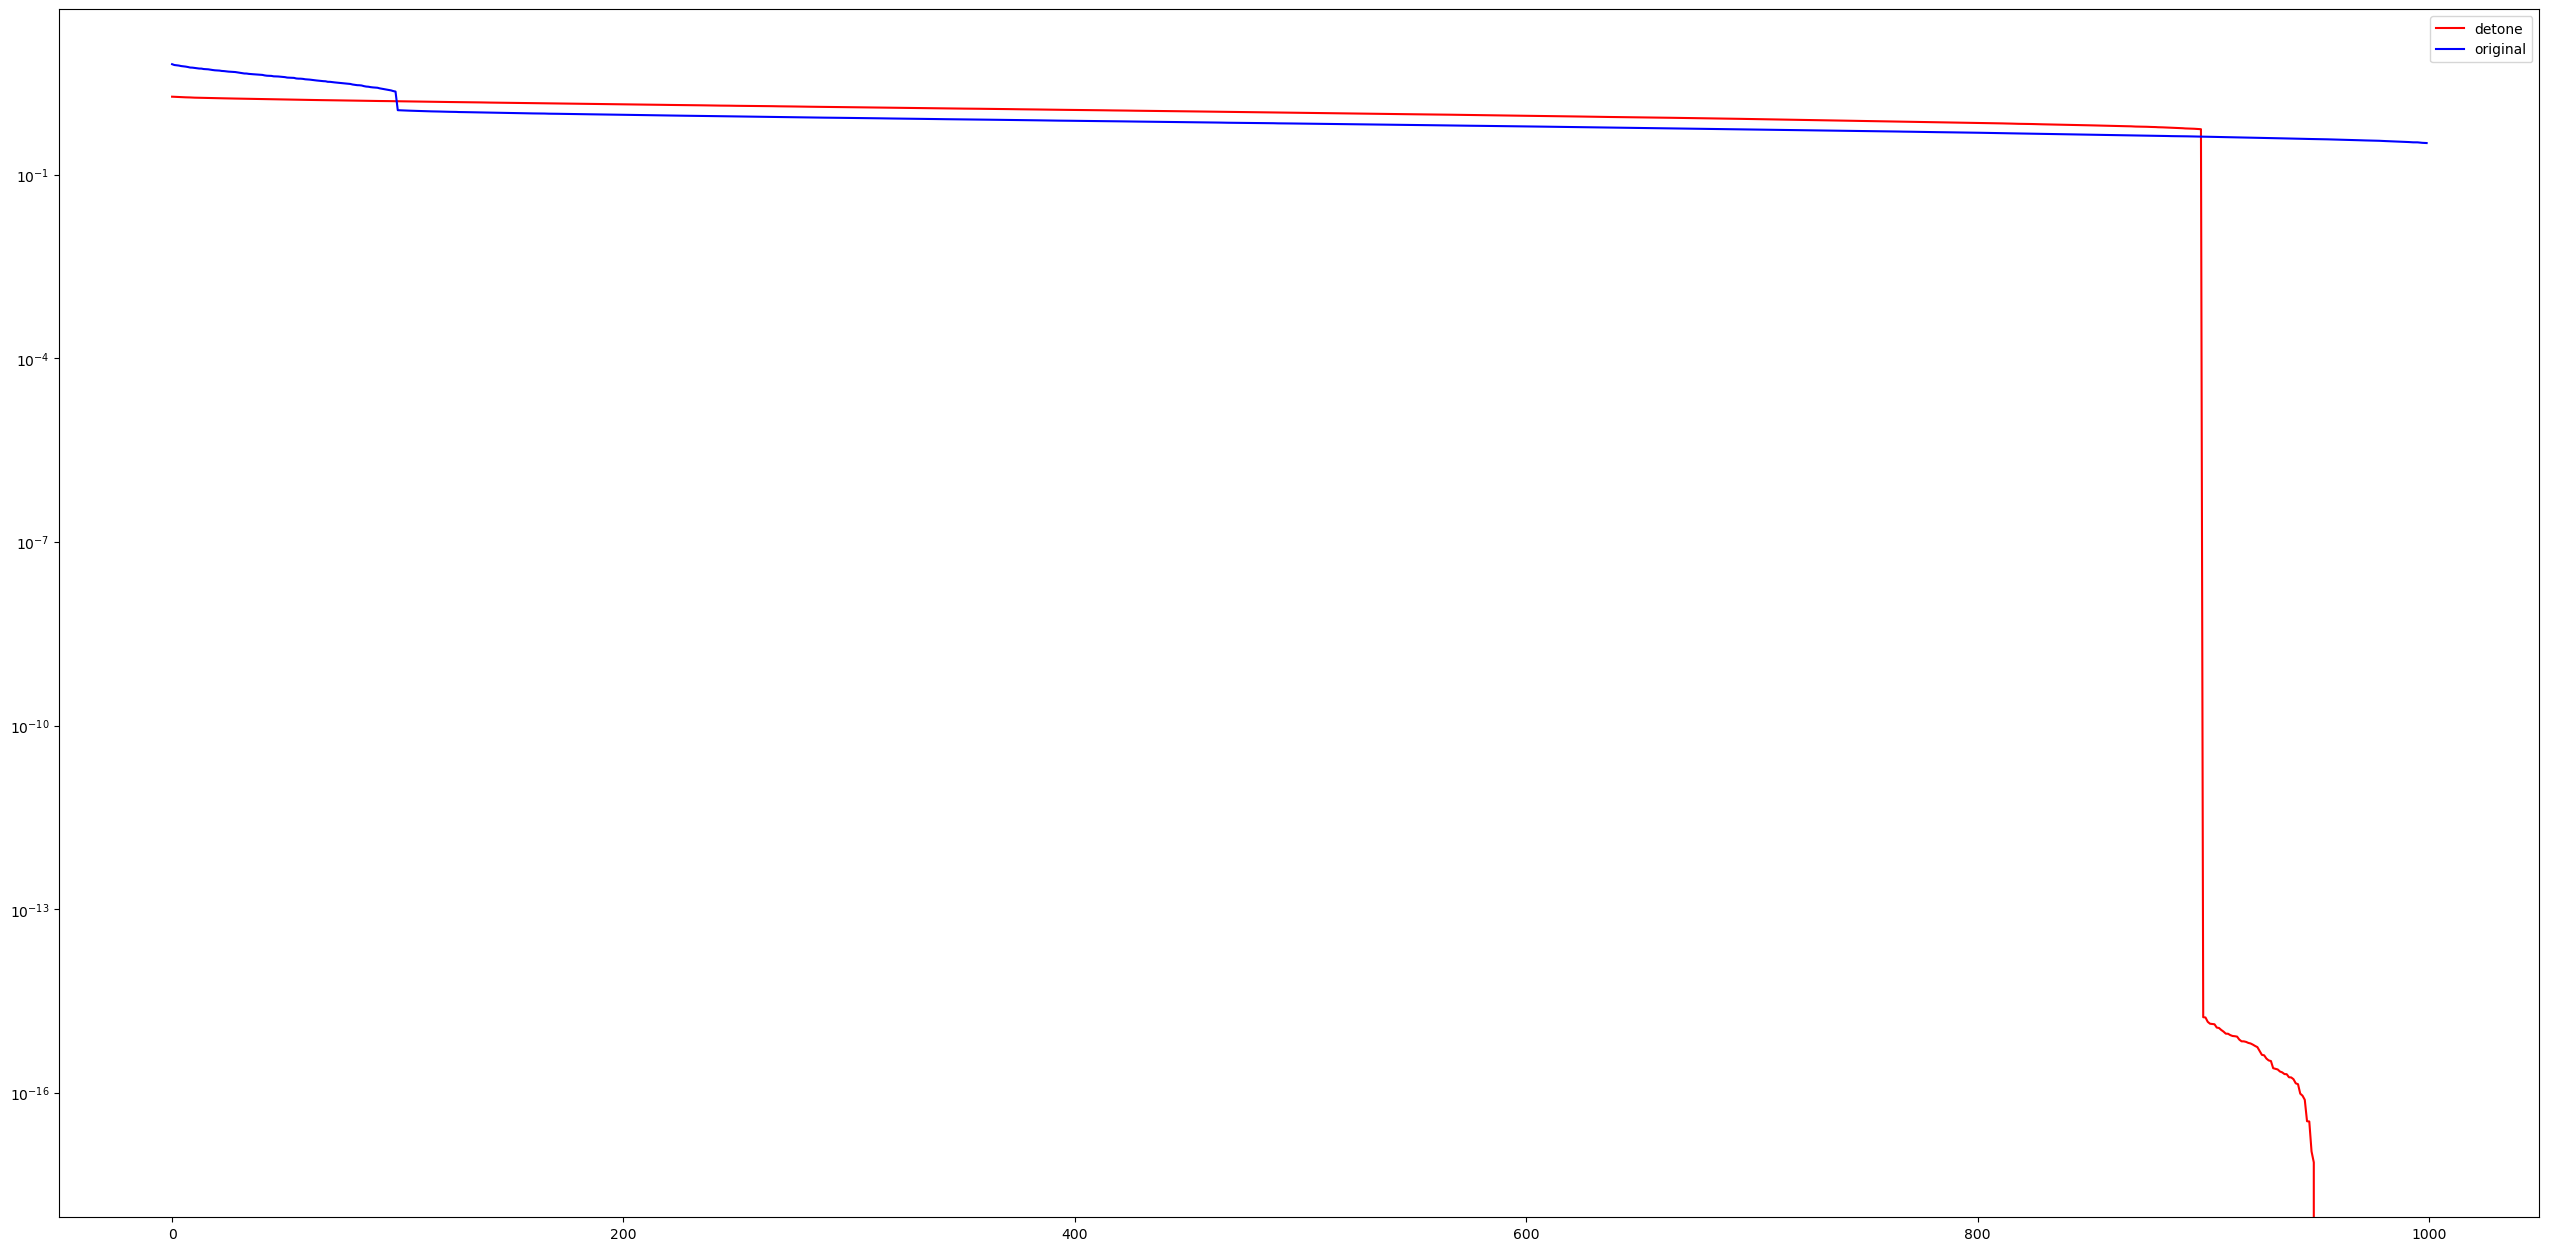

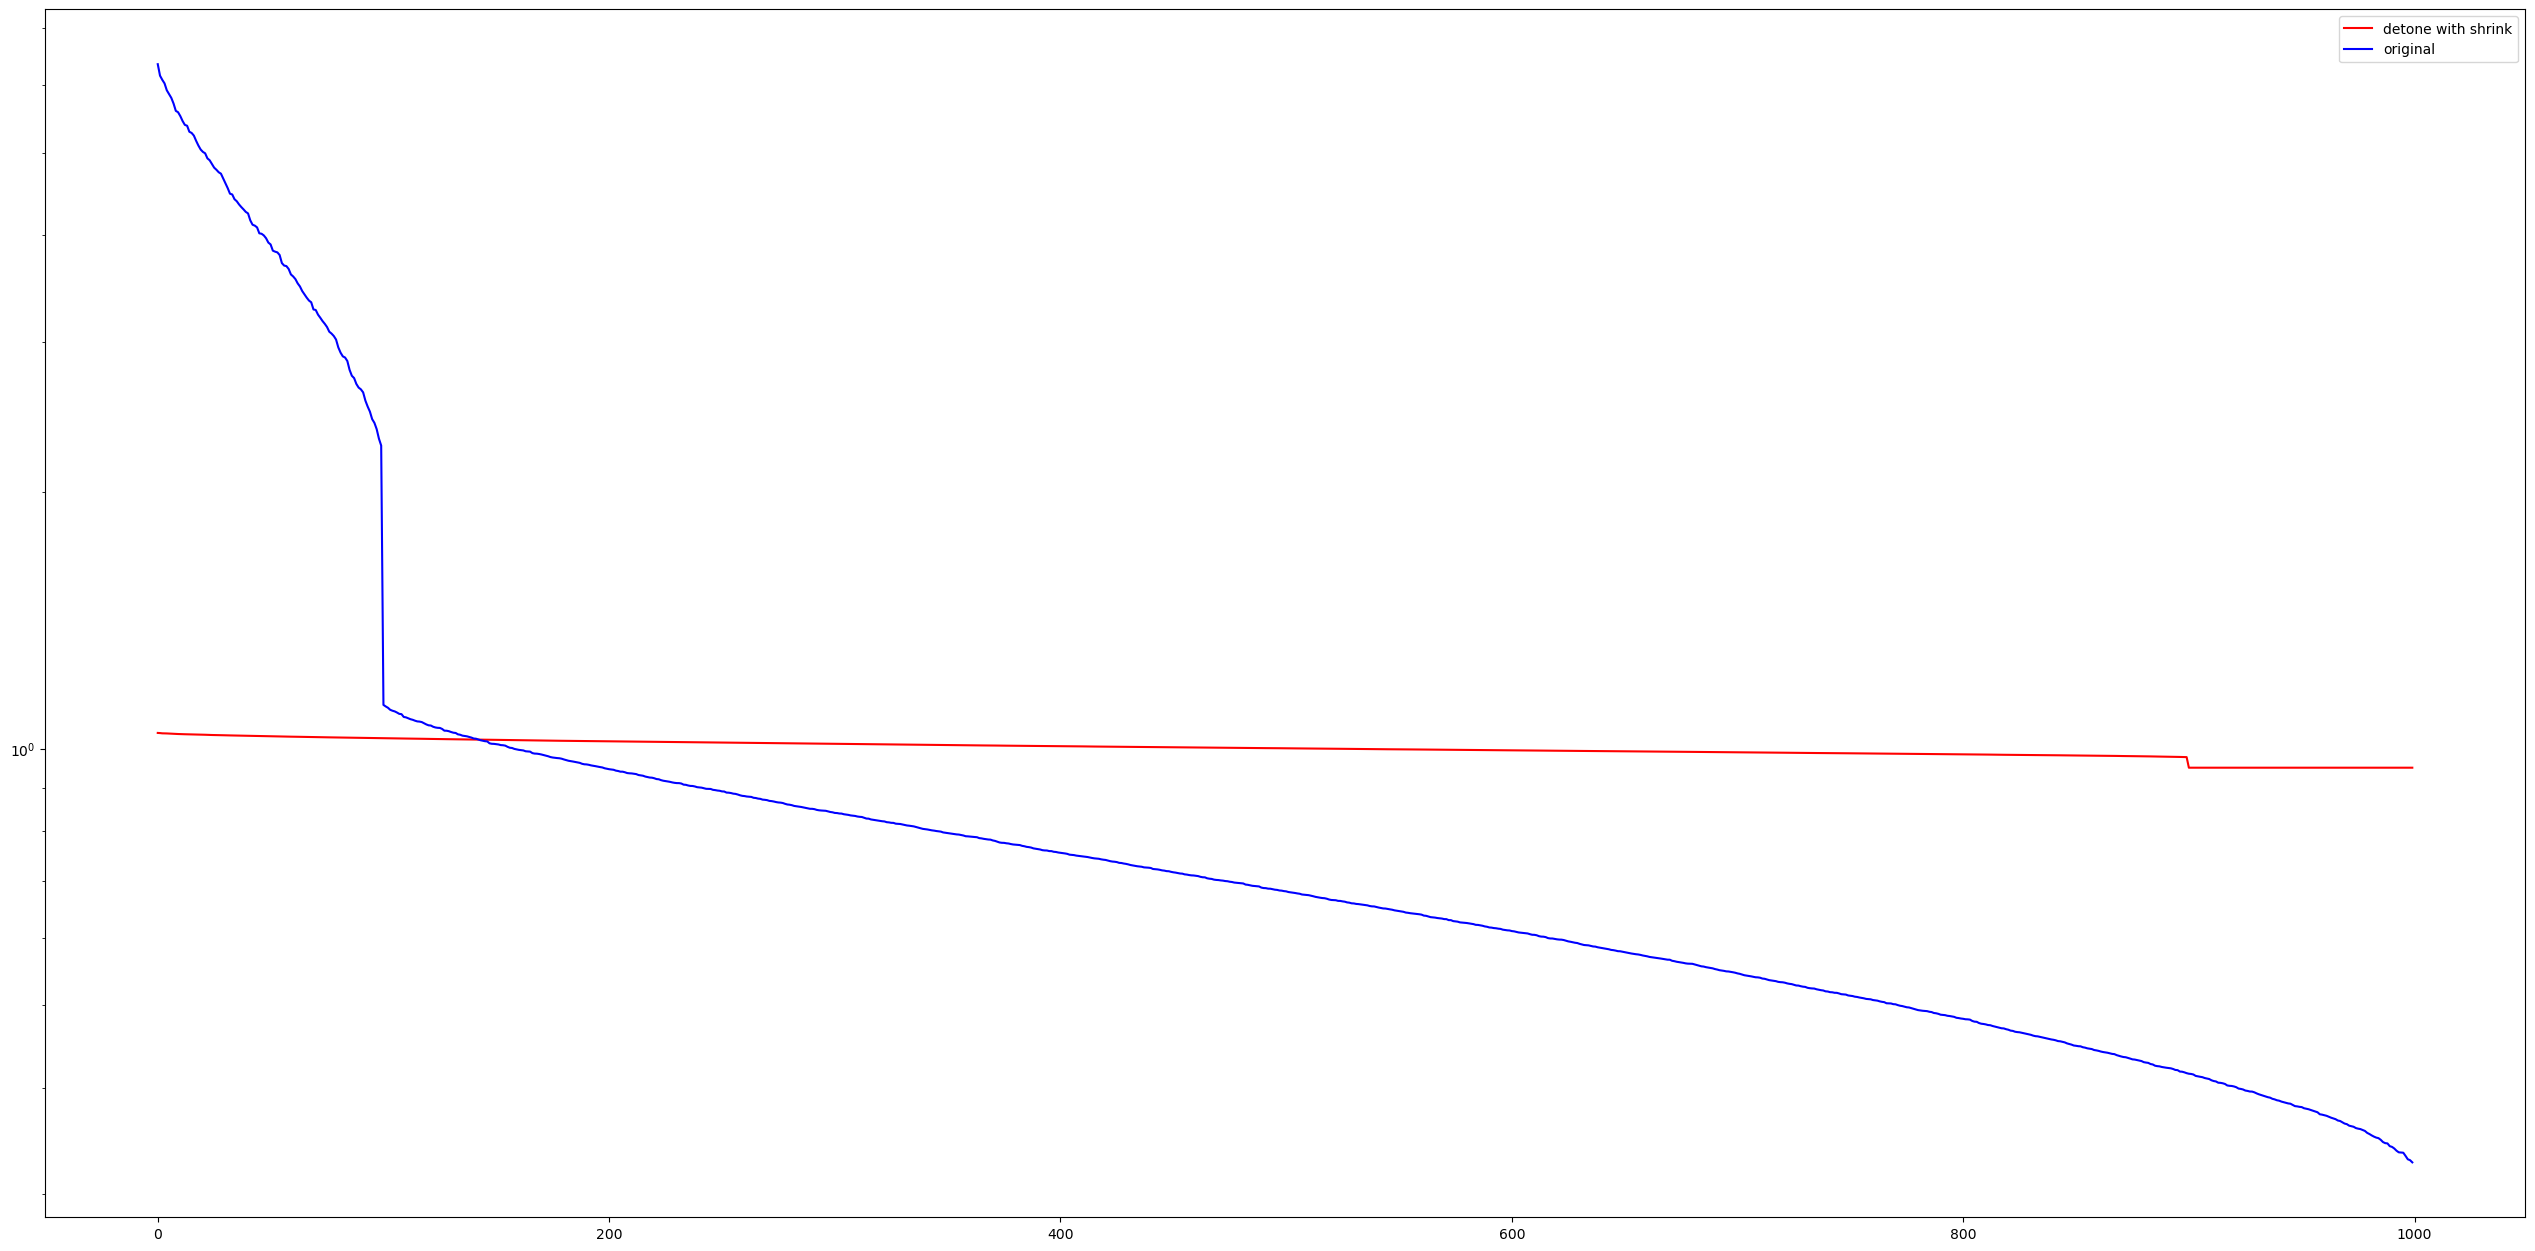

In [8]:
from finance_ml.denoising import detone_corr

plt.figure()
corr1 = detone_corr(e_val0, e_vec0, n_facts0, shrinkage=False)
e_val1, e_vec1 = getPCA(corr1)
plt.plot(np.diag(e_val1), color='r', label='detone');
plt.plot(np.diag(e_val0), color='b', label='original');
plt.yscale('log');
plt.legend();

plt.figure()
corr1 = detone_corr(e_val0, e_vec0, n_facts0, shrinkage=True, alpha=0.05)
e_val1, e_vec1 = getPCA(corr1)
plt.plot(np.diag(e_val1), color='r', label='detone with shrink');
plt.plot(np.diag(e_val0), color='b', label='original');
plt.yscale('log');
plt.legend();

# Portfolio Optimizmation Experiments

We conduct experiments on artificially generated correlation/covariance matrix.
`form_true_matrix` generates block matrix, where `n_blocks`, `bsize`, and `bcorr` are the number of blocks, block size, and correlation, respectively. After generating blocks, we add some noise ranged at [0.02, 0.5] as a standard deviation for each column.

In [6]:
from finance_ml.experiments import form_true_matrix

n_blocks = 10
bsize = 50
bcorr = 0.5
np.random.seed(0)
mu0, cov0 = form_true_matrix(n_blocks, bsize, bcorr, is_shuffle=False)

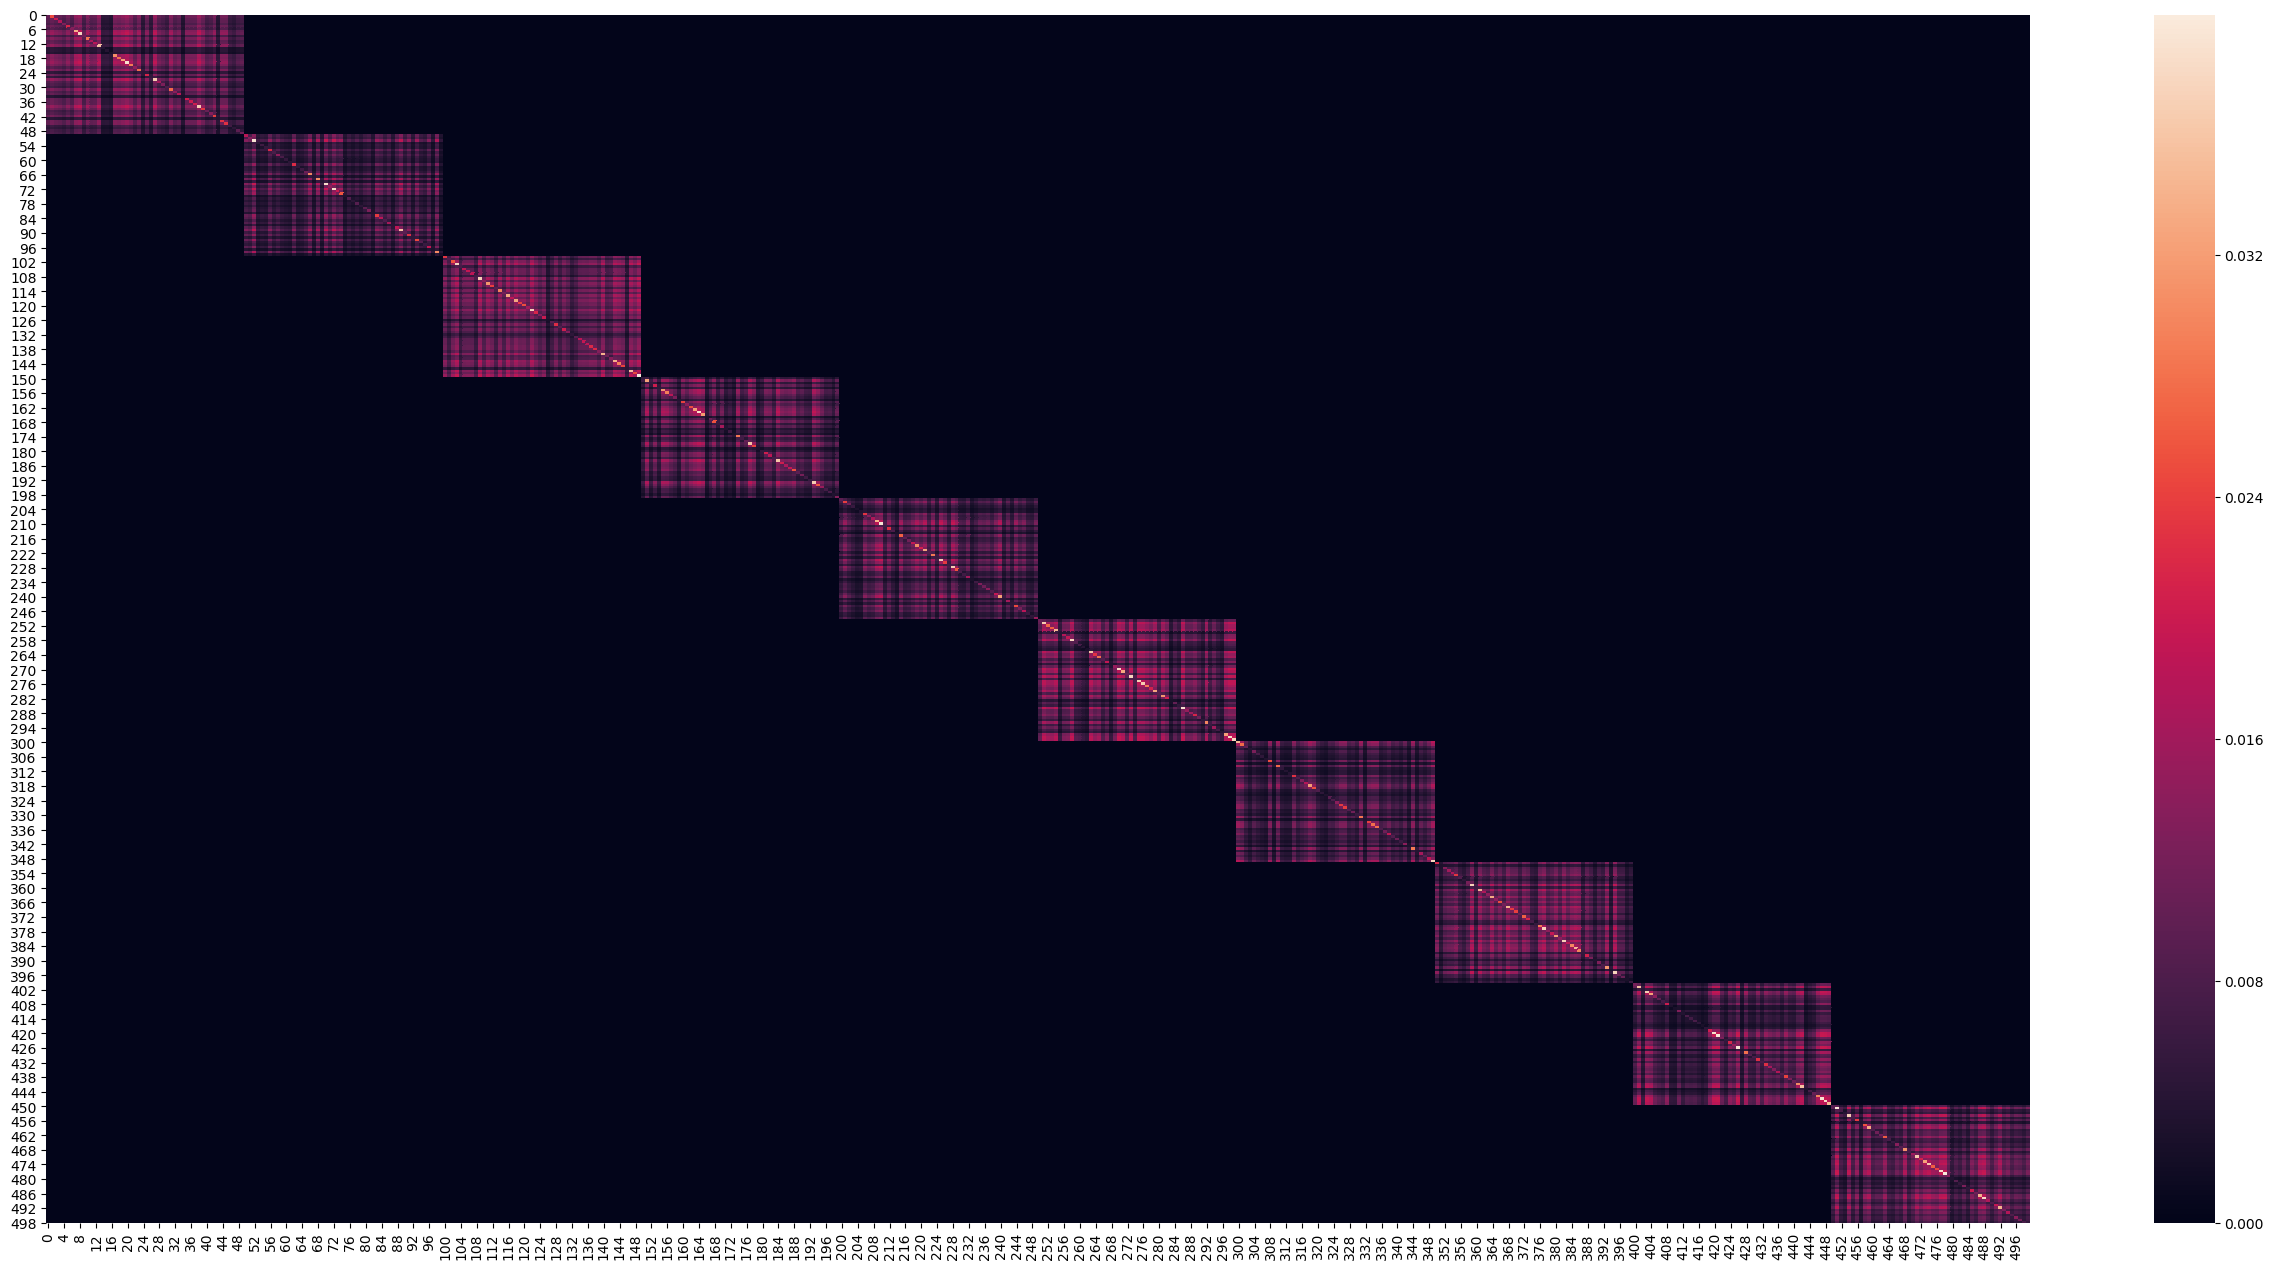

In [7]:
import seaborn as sns

sns.heatmap(cov0);

Before shuffling, you see correlated blocks in covariance matrix.

In [8]:
from finance_ml.experiments import form_true_matrix

n_blocks = 10
bsize = 50
bcorr = 0.5
np.random.seed(0)
mu0, cov0 = form_true_matrix(n_blocks, bsize, bcorr, is_shuffle=True)

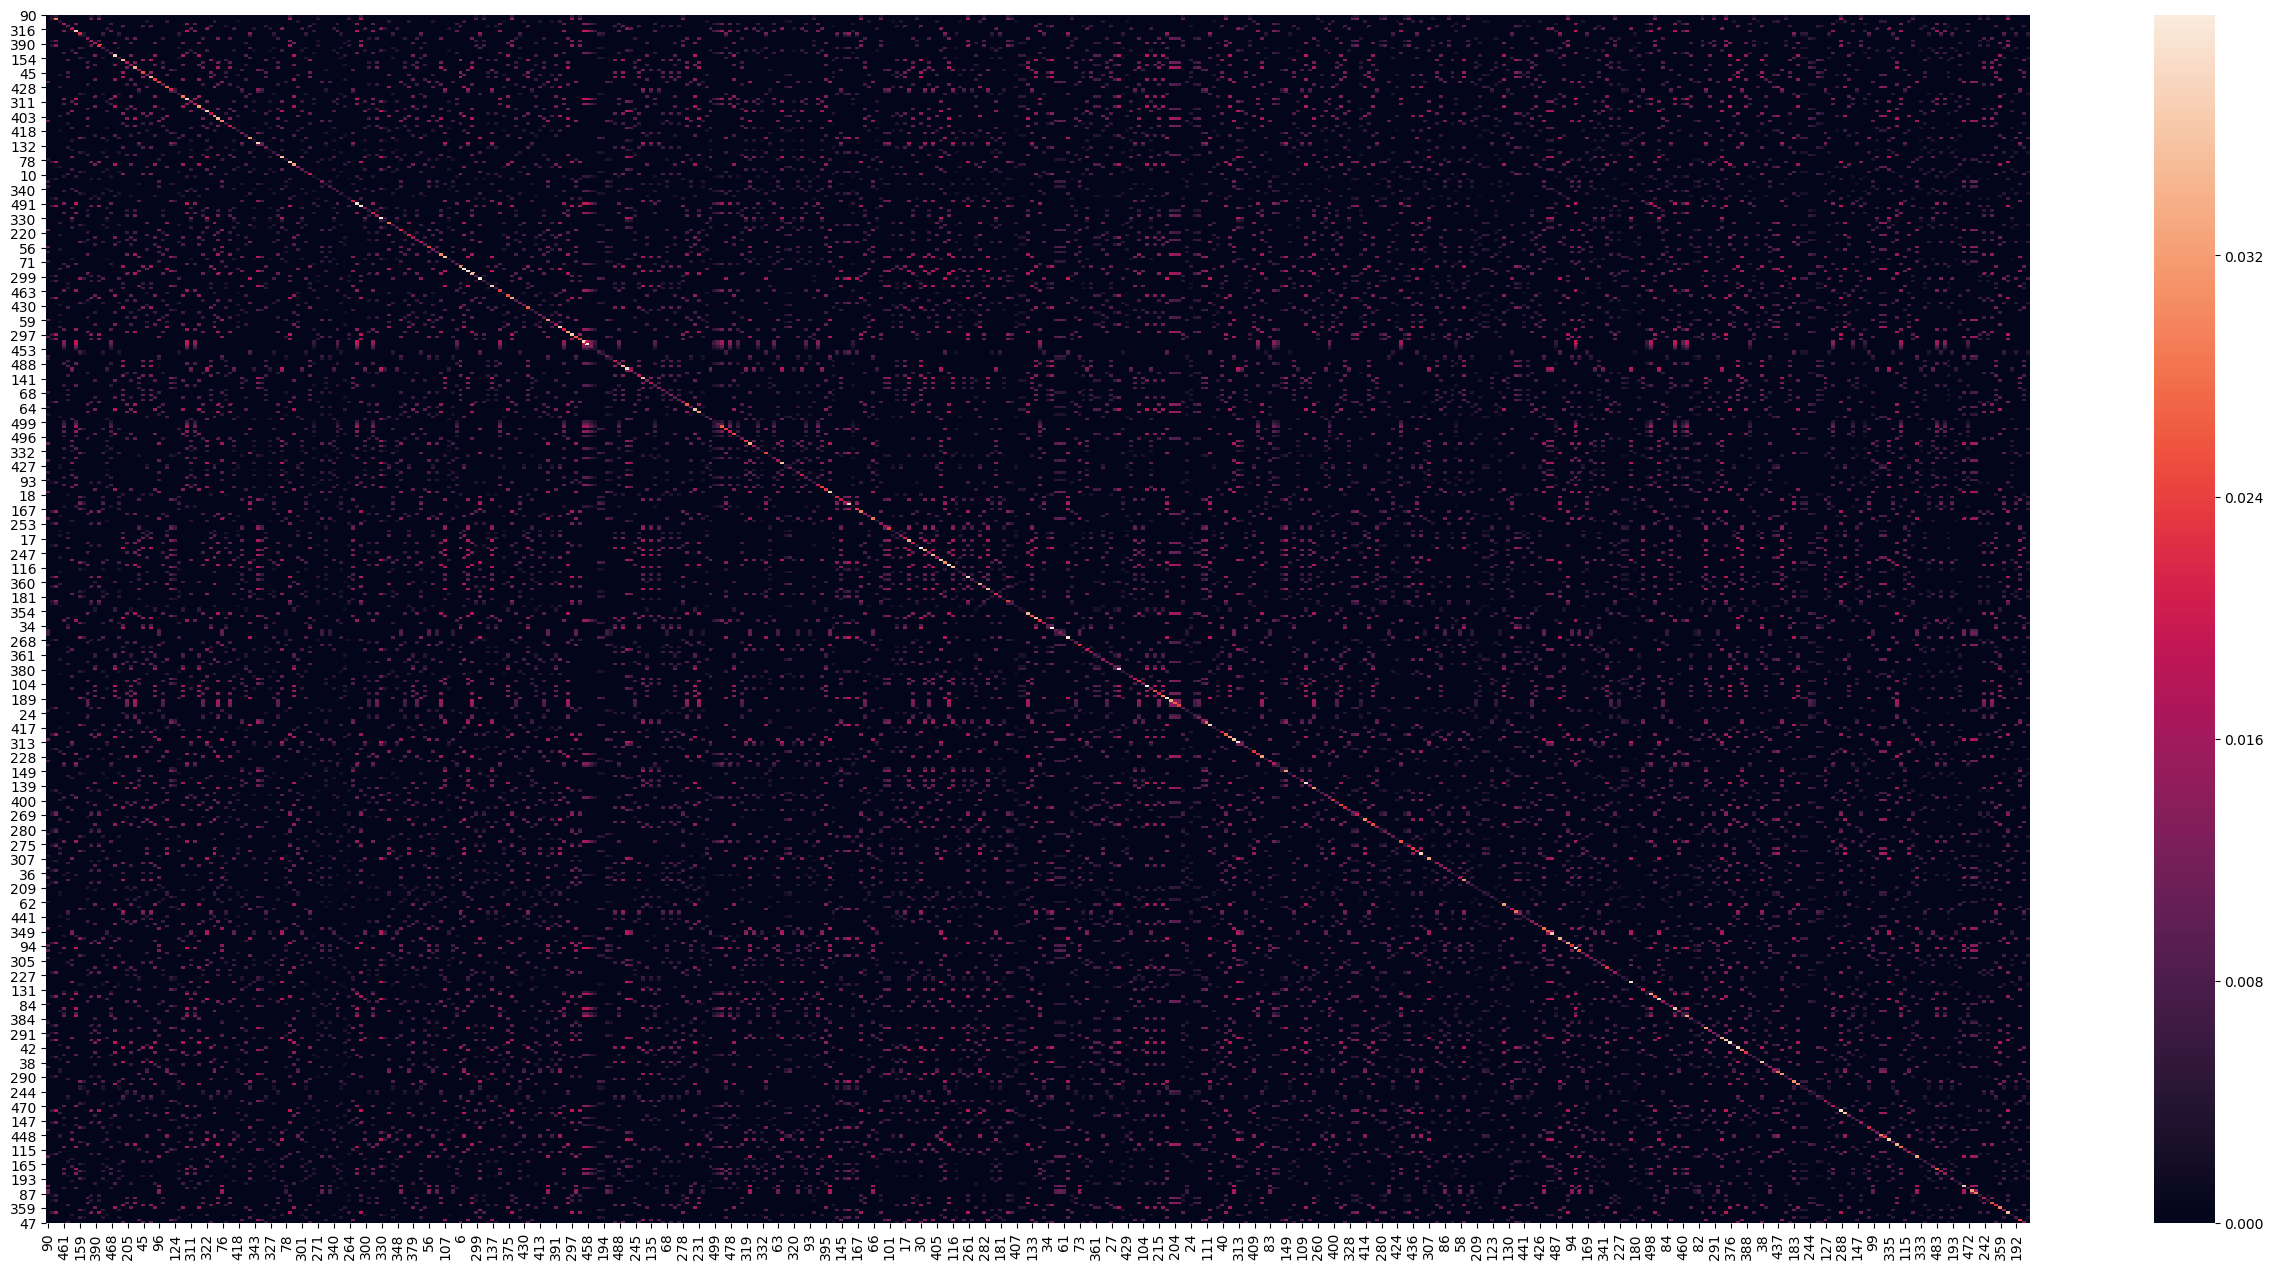

In [9]:
import seaborn as sns

sns.heatmap(cov0);

With `mu0` and `cov0`, generate samples through `simulate_mu_cov`. For each trial, we estimate optimal portfolio weights and compare the accuracy of the estimation before and after denoising.

In [10]:
from finance_ml.experiments import simulate_mu_cov
from finance_ml.denoising import denoise_cov, opt_portfolio
from tqdm import tqdm_notebook


def experiments(mu0, cov0, n_obs, n_trials, bwidth, shrink, min_var_portf):
    # weightt before denoising
    w1 = pd.DataFrame(columns=list(range(cov0.shape[0])), index=list(range(n_trials)), dtype=float)
    # weights after denoising
    w1_d = w1.copy(deep=True)
    for i in tqdm_notebook(range(n_trials)):
        # Generate samples and estimate empirical momentums
        mu1, cov1 = simulate_mu_cov(mu0, cov0, n_obs=n_obs, shrink=shrink)
        if min_var_portf:
            mu1 = None
        cov1_d = denoise_cov(cov1, n_obs * 1. / cov1.shape[1], bwidth)
        w1.loc[i] = opt_portfolio(cov1, mu1).flatten()
        w1_d.loc[i] = opt_portfolio(cov1_d, mu1).flatten()
    mu0_ = mu0.copy()
    if min_var_portf:
        mu0_ = None
    w0 = opt_portfolio(cov0, mu0_)
    w0 = np.repeat(w0.T, w1.shape[0], axis=0)
    rmsd = np.mean((w1 - w0).values.flatten() ** 2) ** 0.5
    rmsd_d = np.mean((w1_d - w0).values.flatten() ** 2) ** 0.5
    return rmsd, rmsd_d

In the experiment, we use additional parameter called `shrink`. If True, covariance is estimated through Ledoit-Wolf closed formula. 


With shrink 

In [11]:
n_obs = 1000
n_trials = 100
bwidth = 0.01
shrink = False
min_var_portf = True
np.random.seed(0)
rmsd, rmsd_d = experiments(mu0, cov0, n_obs, n_trials, bwidth, shrink, min_var_portf)
print(f'rmsd={rmsd}, rmsd_d={rmsd_d}')


rmsd=0.004917937784984864, rmsd_d=0.0011418487067422088


Without shrink

In [12]:
n_obs = 1000
n_trials = 100
bwidth = 0.01
shrink = True
min_var_portf = True
np.random.seed(0)
rmsd, rmsd_d = experiments(mu0, cov0, n_obs, n_trials, bwidth, shrink, min_var_portf)
print(f'rmsd={rmsd}, rmsd_d={rmsd_d}')


rmsd=0.0034544440296207105, rmsd_d=0.0013716729520853086


You see that the improvement from denoising is greater than Ledoit-Wolf shrink improvement.